# Green Prism — Impact Estimator (Actual CO₂ Only, No Claimed)

This notebook trains an **Impact Estimator** model that predicts **actual annual CO₂ emissions avoided** (tons CO₂e)
for green projects using:

- Project description text (from ADB Green & Blue Bond Impact Report tabs)
- Project category (RE/EE, Transport, Water/Urban, Blue)
- Financing amount (USD, if available)

THis **does not** use any claimed / promised impact here. The model is:

> `f(project_text, metadata) → actual_co2_tons`

Later, at inference time in the app, will:

- Show *“Predicted annual CO₂ avoided: X tons (± uncertainty)”*
- Optionally compare this to any claimed number a user provides to get a gap.


## 1. Imports & Path Setup

In [ ]:
!pip install --upgrade sentence-transformers torch

  Using cached torch-2.9.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cusparse_cu12-12.5.8.93-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

import torch
from sentence_transformers import SentenceTransformer

# Repo layout assumptions:
#   repo_root/
#     backend/
#       app/
#         data/impact_training_dataset.csv
#
from pathlib import Path

DATA_PATH = Path("/impact_training_dataset.csv")

print("DATA_PATH:", DATA_PATH)

def clean_text(text: str | None) -> str:
    if not text:
        return ""
    return " ".join(str(text).split())


DATA_PATH: /impact_training_dataset.csv


## 2. Load & Inspect Training Data

In [2]:
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Training CSV not found at {DATA_PATH}.\n"
        "Copy your consolidated ADB-based impact_training_dataset.csv to this path."
    )

df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
df.head()


Raw shape: (96, 5)


,project_name,actual_co2_tons,total_project_cost_mil_usd,category,log_co2
0,Indonesia: Java–Bali Electricity Distribution ...,330000,120.00,EE,12.706851
1,"China, People's Republic of: Integrated Renewa...",1000000,152.54,RE,13.815512
2,Papua New Guinea: Town Electrification Investm...,35000,71.60,RE,10.463132
3,"China, People’s Republic of:Agricultural and\n...",255200,200.00,RE,12.449807
4,Regional: Southeast Asia Energy Efficiency Pro...,90000,200.00,EE,11.407576


### 2.1 Expected Columns & Basic Cleaning

In [3]:
# Load CSV
df = pd.read_csv(DATA_PATH)

# Map your new CSV columns to the internal names used in the notebook
col_map = {
    "project_name": "text",
    "actual_co2_tons": "actual_co2_tons",
    "total_project_cost_mil_usd": "total_project_cost_mil_usd",
    "category": "project_category",
}
df = df.rename(columns=col_map)

# Required for intensity: text, CO2, and project cost
required_cols = ["text", "actual_co2_tons", "total_project_cost_mil_usd"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Basic cleaning
df = df.dropna(subset=required_cols).copy()
df["text"] = df["text"].astype(str)
df["actual_co2_tons"] = pd.to_numeric(df["actual_co2_tons"], errors="coerce")
df["total_project_cost_mil_usd"] = pd.to_numeric(
    df["total_project_cost_mil_usd"], errors="coerce"
)

df = df.dropna(subset=["actual_co2_tons", "total_project_cost_mil_usd"]).copy()
df = df[df["total_project_cost_mil_usd"] > 0].copy()

# For backwards compatibility with the rest of the notebook:
# create amount_issued_usd (in dollars) from cost in $ million
df["amount_issued_usd"] = df["total_project_cost_mil_usd"] * 1_000_000.0

print("After cleaning:", df.shape)
df[["actual_co2_tons", "total_project_cost_mil_usd"]].describe()


After cleaning: (77, 6)


,actual_co2_tons,total_project_cost_mil_usd
count,7.700000e+01,77.000000
mean,2.597660e+05,262.438571
std,4.429366e+05,241.248814
min,0.000000e+00,7.000000
25%,2.487000e+04,62.000000
50%,7.480000e+04,200.000000
75%,3.195050e+05,360.000000
max,3.000000e+06,946.500000


In [4]:
# ----- compute intensity target -----

# amount in $ millions (already in that unit)
df["amount_musd"] = df["total_project_cost_mil_usd"]

# tCO2 avoided per $1M invested
df["intensity_tco2_per_musd"] = df["actual_co2_tons"] / df["amount_musd"]

# Drop weird / non-positive intensities
df = df[df["intensity_tco2_per_musd"] > 0].copy()

# Train on log1p(intensity) to reduce skew
df["log_intensity"] = np.log1p(df["intensity_tco2_per_musd"])

df[["actual_co2_tons", "amount_musd", "intensity_tco2_per_musd", "log_intensity"]].describe()


,actual_co2_tons,amount_musd,intensity_tco2_per_musd,log_intensity
count,7.600000e+01,76.000000,76.000000,76.000000
mean,2.631839e+05,265.638421,1163.597022,6.030681
std,4.448564e+05,241.201338,1688.434831,1.921298
min,1.000000e+00,7.000000,0.003458,0.003452
25%,2.631750e+04,65.165000,209.232459,5.347786
50%,7.638950e+04,200.000000,619.577200,6.428386
75%,3.221288e+05,364.112500,1310.714730,7.179060
max,3.000000e+06,946.500000,8005.700000,8.988034


## 3. Clean Text

In [5]:
df["clean_text"] = df["text"].fillna("").astype(str).apply(clean_text)
df[["clean_text"]].head()

,clean_text
0,Indonesia: Java–Bali Electricity Distribution ...
1,"China, People's Republic of: Integrated Renewa..."
2,Papua New Guinea: Town Electrification Investm...
3,"China, People’s Republic of:Agricultural and M..."
4,Regional: Southeast Asia Energy Efficiency Pro...


## 4. Metadata Features (Numeric + Categorical)

In [6]:
# Define which numeric & categorical columns to use (if present)
num_cols = []
if "amount_musd" in df.columns:
    num_cols.append("amount_musd")

cat_cols = []
if "category" in df.columns:
    cat_cols.append("category")

print("Numeric feature columns:", num_cols)
print("Categorical feature columns:", cat_cols)

# Clean numeric
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

# Simple label encoding for categoricals
cat_maps = {}
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN").astype(str)
    uniques = sorted(df[col].unique())
    mapping = {val: i for i, val in enumerate(uniques)}
    cat_maps[col] = mapping
    df[col + "_idx"] = df[col].map(mapping)

# Build numeric feature array
num_features = []

for col in num_cols:
    vals = df[col].astype(float).values.reshape(-1, 1)
    num_features.append(vals)

# Add categorical indices as numeric features
for col in cat_cols:
    idx_vals = df[col + "_idx"].astype(float).values.reshape(-1, 1)
    num_features.append(idx_vals)

if num_features:
    num_features = np.concatenate(num_features, axis=1)
else:
    num_features = np.zeros((len(df), 0), dtype=np.float32)

print("Numeric+cat feature matrix shape:", num_features.shape)


Numeric feature columns: ['amount_musd']
Categorical feature columns: []
Numeric+cat feature matrix shape: (76, 1)


## 5. Text Embeddings with MiniLM (SentenceTransformer)

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

st_model = SentenceTransformer(MODEL_NAME, device=DEVICE)
print("Loaded sentence-transformers model:", MODEL_NAME, "on", DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded sentence-transformers model: sentence-transformers/all-MiniLM-L6-v2 on cuda


In [8]:
texts_clean = df["clean_text"].tolist()
len(texts_clean), max(len(t) for t in texts_clean[:1000])


(76, 553)

In [9]:
texts_clean = df["clean_text"].tolist()

print("Embedding texts with MiniLM...")
text_embeddings = st_model.encode(texts_clean, batch_size=16, show_progress_bar=True, device="cpu",)
text_embeddings = np.asarray(text_embeddings, dtype=np.float32)
print("Embeddings shape:", text_embeddings.shape)

Embedding texts with MiniLM...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Embeddings shape: (76, 384)


### 5.1 Build Feature Matrix X and Target y

In [10]:
X = np.concatenate([text_embeddings, num_features], axis=1)

# Train target: log1p(intensity = tCO2 per $1M)
y = df["log_intensity"].astype(float).values

# Keep these around for metrics
y_actual = df["actual_co2_tons"].astype(float).values
amount_musd = df["amount_musd"].astype(float).values

print("X shape:", X.shape, "  y (log_intensity) shape:", y.shape)

X shape: (76, 385)   y (log_intensity) shape: (76,)


## 6. Train XGBoost Regressor (Predict Actual CO₂)

In [11]:
X_train, X_val, y_train, y_val, y_actual_train, y_actual_val, amt_train, amt_val = train_test_split(
    X, y, y_actual, amount_musd, test_size=0.2, random_state=42
)

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=4,
)

xgb.fit(X_train, y_train)
y_pred_log = xgb.predict(X_val)

# y_val & y_pred_log are in log1p(intensity) space

# Back to intensity (tCO2 per $1M)
y_val_intensity = np.expm1(y_val)
y_pred_intensity = np.expm1(y_pred_log)

# Convert to actual tons using the project-specific cost
y_val_tons = y_val_intensity * amt_val
y_pred_tons = y_pred_intensity * amt_val

rmse = np.sqrt(mean_squared_error(y_val_tons, y_pred_tons))
r2 = r2_score(y_val_tons, y_pred_tons)

print(f"Validation RMSE: {rmse:,.0f} tons CO2/year")
print(f"Validation R^2: {r2:.3f}")

print("Actual stats: mean", y_val_tons.mean(), "std", y_val_tons.std())
print("Pred stats:   mean", y_pred_tons.mean(), "std", y_pred_tons.std())

Validation RMSE: 789,479 tons CO2/year
Validation R^2: -0.195
Actual stats: mean 405692.25000000023 std 722124.5048449492
Pred stats:   mean 214604.37897397997 std 348647.72340572276


### 6.1 Diagnostic Plot

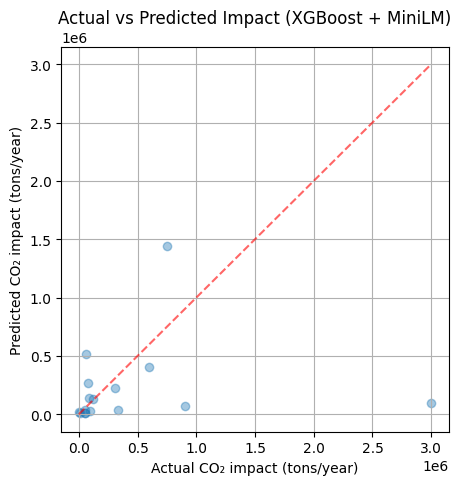

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(y_val_tons, y_pred_tons, alpha=0.4)
plt.xlabel("Actual CO₂ impact (tons/year)")
plt.ylabel("Predicted CO₂ impact (tons/year)")
plt.title("Actual vs Predicted Impact (XGBoost + MiniLM)")

min_val = float(min(y_val_tons.min(), y_pred_tons.min()))
max_val = float(max(y_val_tons.max(), y_pred_tons.max()))
plt.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.6)

plt.grid(True)
plt.show()

## 7. Save Model Artifact

In [16]:
from joblib import dump

MODEL_PATH = "impact_estimator_xgb_minilm.joblib"

artifact = {
    "model": xgb,              # predicts log1p(tCO2_per_$1M)
    "text_model_name": MODEL_NAME,
    "cat_maps": cat_maps,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
}

dump(artifact, MODEL_PATH)
print("Saved impact estimator model to:", MODEL_PATH)

Saved impact estimator model to: impact_estimator_xgb_minilm.joblib


## 8. Inference Helper — Predict Actual CO₂ for One Project

In [17]:
from joblib import load

def load_impact_estimator(model_path: Path = MODEL_PATH):
    return load(model_path)

def _encode_metadata(row: dict, artifact: dict) -> np.ndarray:
    num_cols = artifact["num_cols"]
    cat_cols = artifact["cat_cols"]
    cat_maps = artifact["cat_maps"]

    feats = []

    # numeric
    for col in num_cols:
        val = row.get(col, 0.0)
        try:
            v = float(val)
        except Exception:
            v = 0.0
        feats.append(v)

    # categorical as label indices
    for col in cat_cols:
        mapping = cat_maps[col]
        raw_val = str(row.get(col, "UNKNOWN"))
        idx = mapping.get(raw_val, mapping.get("UNKNOWN", 0))
        feats.append(float(idx))

    return np.array(feats, dtype=np.float32).reshape(1, -1)

@torch.no_grad()
def predict_actual_impact(
    text: str,
    meta: dict,
    artifact: dict,
    st_model_for_inference: SentenceTransformer,
):
    """
    Predict actual annual CO2 emissions avoided (tons/year).

    Returns:
      {
        'predicted_impact_mean': float,
        'predicted_impact_std': float  # simple uncertainty proxy
      }
    """
    cleaned = clean_text(text)
    emb = st_model_for_inference.encode([cleaned])
    emb = np.asarray(emb, dtype=np.float32)  # (1, H)

    meta_vec = _encode_metadata(meta, artifact)  # (1, M)

    feats = np.concatenate([emb, meta_vec], axis=1)  # (1, H+M)

    model = artifact["model"]
    pred = float(model.predict(feats)[0])

    # Very simple uncertainty heuristic: 15% of magnitude
    pred_std = float(abs(pred) * 0.15)

    return {
        "predicted_impact_mean": pred,
        "predicted_impact_std": pred_std,
    }

artifact_loaded = load_impact_estimator()

# Example usage on the first row
example_row = df.iloc[0]
example_meta = {}

# Populate meta from available columns
for col in artifact_loaded["num_cols"] + artifact_loaded["cat_cols"]:
    if col in df.columns:
        example_meta[col] = example_row.get(col)

example_result = predict_actual_impact(
    text=example_row["text"],
    meta=example_meta,
    artifact=artifact_loaded,
    st_model_for_inference=st_model,
)

example_row["actual_co2_tons"], example_result


(np.int64(330000),
 {'predicted_impact_mean': 5.707595348358154,
  'predicted_impact_std': 0.8561393022537231})

---
## 9. Integration Notes

Once this notebook has been run and the model artifact
`impact_estimator_xgb_minilm.joblib` is saved under `backend/app/models/`, need to:

1. Create a backend module, e.g. `app/ml/impact_estimator.py`, that:
   - loads the artifact once on import
   - exposes a function like `estimate_impact(text: str, meta: dict) -> dict`.

2. In FastAPI scoring service (`scoring_service.py`), need to call that
   function alongside your transparency score computation.

3. In the React UI, display:
   - **Predicted annual CO₂ avoided:** `X tons/year`
   - **Uncertainty band:** `X ± std`
   - Optionally, an efficiency metric like `tons CO₂ / $ million` if we
     pass `amount_issued_usd` in `meta`.

This model does **not** depend on any claimed/target values and can be
used independently. Later, if when adding claimed impact for some bonds,
will compute `gap = claimed - predicted_impact_mean` at inference
time without retraining this model.
